In [65]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import tikzplotlib

from src.config import SAT_TEST_SEQ

ENCODING_DIR = "./results/encoding"
POLICY_DIR = "./results/policy"
SEARCH_DIR = "./results/search"
COLOURS = ["blue", "orange", "green", "red"]

NAME_TO_SOLVER = {
    "cr": "cryptominisat",
    "ca": "cadical",
    "gl": "glucose",
    "ki": "kissat",
    "ma": "maple"
}

NAME_TO_POLICY = {
    "bs": "binary_search_policy",
    "ls": "linear_search_policy",
    "db": "double_binary_policy",
    "dl": "double_linear_policy"
}

In [66]:
# Get a list of the results from a directory
def get_result_dicts(dir_path: str) -> list[dict[str, float | str]]:
    results = []
    for file_name in filter(lambda x: x.endswith(".csv"), os.listdir(dir_path)):
        # Open the csv file
        file_dict = pd.read_csv(os.path.join(dir_path, file_name)).to_dict()
        # For each header in the csv where (key1=name,val1=dict(key=row_num,val=val_at_row))
        valid = True
        for key1, val1 in file_dict.items():
            # If the value is a string, convert from a dict of strings to 1 string
            if len(val1) == 0:
                valid = False
                break
            if type(val1[0]) == str:
                file_dict[key1] = val1[0]
            # Else find the average of the values
            else:
                values = [v for v in val1.values()]
                file_dict[key1] = sum(values) / len(values)
        # If the policy and or solver is not in the csv, get it from the name
        if "policy" not in file_dict.keys():
            file_dict["policy"] = NAME_TO_POLICY[re.search(r"_(\w{2})p", file_name).group(1)]
        if "solver" not in file_dict.keys():
            file_dict["solver"] = NAME_TO_SOLVER[re.search(r"_(\w{2})s", file_name).group(1)]
        if "ver" not in file_dict.keys():
            file_dict["ver"] = int(re.search(r"_v(\d)_", file_name).group(1))
        if "len" not in file_dict.keys():
            file_dict["len"] = int(re.search(r"length-(\d+)-", file_name).group(1))
        if valid:
            results.append(file_dict)
    return results

# Helper functions for working with return value of the above function
def get_all_vars_for(result_dicts: list[dict[str, float | str]], var_name: str) -> list:
    return sorted(set(x[var_name] for x in result_dicts))

def filter_by(result_dicts: list[dict[str, float | str]], var_name: str, var: str | float) -> list:
    return [x for x in result_dicts if x[var_name] == var]

In [67]:
SHOW_ENCODING_RESULTS = True
SHOW_SAT_RESULTS = True

# Encoding Test Results
The following code compares for each policy the best combination of `[search-policy][sat-solver][encoding-version]`

                             	 [v0,      v1,     v2]
binary_search_policy glucose 	 [39.3346, 27.677, 19.9937] 	ver_avg = 29.0018
binary_search_policy kissat 	 [30.1284, 12.1497, 9.514] 	ver_avg = 17.264
policy_avg = 23.1329

double_binary_policy glucose 	 [41.0665, 71.9762, 17.763] 	ver_avg = 43.6019
double_binary_policy kissat 	 [32.103, 13.4766, 10.9016] 	ver_avg = 18.8271
policy_avg = 31.2145

double_linear_policy glucose 	 [26.5656, 14.7759, 11.741] 	ver_avg = 17.6942
double_linear_policy kissat 	 [26.904, 6.3328, 5.119] 	ver_avg = 12.7853
policy_avg = 15.2398



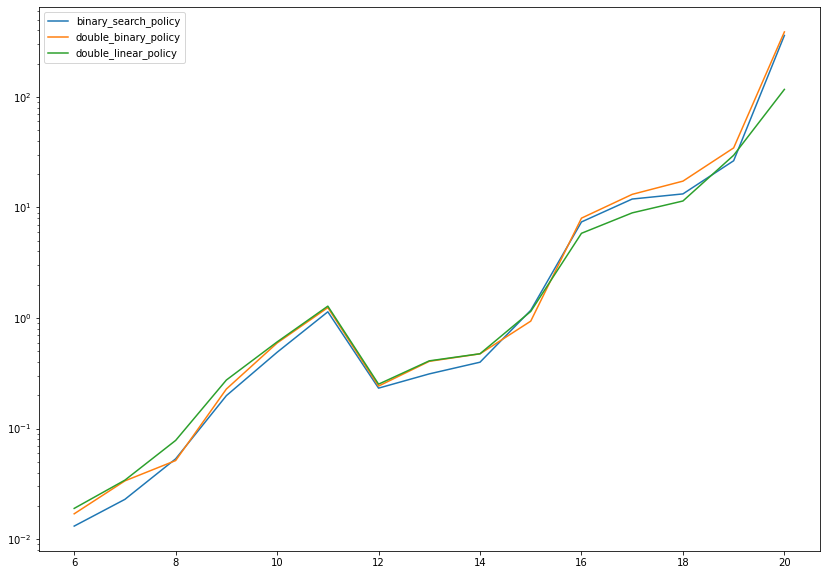

In [68]:
if SHOW_ENCODING_RESULTS:
    #  Compare the performance of each (policy, solver, version) combination
    results = get_result_dicts(POLICY_DIR)
    policies = get_all_vars_for(results, "policy")
    solvers = get_all_vars_for(results, "solver")
    vers = get_all_vars_for(results, "ver")
    lengths = get_all_vars_for(results, "len")

    # Results
    results_each_len: dict[str, dict[str, dict[list[float]]]] = {
        policy: {
            solver: {
                ver: [] for ver in vers
            } for solver in solvers
        } for policy in policies
    }

    print(" " * (1 + len(policies[0]) + len(solvers[0])), "\t", "[v0,      v1,     v2]")
    # Get the times for all policies
    for policy in policies:
        policy_times = []
        # Get the times for all solvers
        for solver in solvers:
            policy_solver_results = filter_by(filter_by(results, "policy", policy), "solver", solver)
            ver_results = []
            # Get the time for all versions
            for ver in vers:
                policy_solver_ver_results = filter_by(policy_solver_results, "ver", ver)
                avg_ver_results = np.mean([x["total_time"] for x in policy_solver_ver_results])
                ver_results.append(round(avg_ver_results, 4))

                # Get the time for all lengths
                for length in lengths:
                    length_results = filter_by(policy_solver_ver_results, "len", length)
                    results_each_len[policy][solver][ver].append(np.mean([x["total_time"] for x in length_results]))

            # Print out the times for current policy and solver
            ver_avg = round(np.mean(ver_results), 4)
            policy_times.append(ver_avg)
            print(policy, solver, "\t", ver_results, f"\t{ver_avg = }")
        
        # Print out the average time for the policy
        policy_avg = round(np.mean(policy_times), 4)
        print(f"{policy_avg = }")
        print()

    # Plot the times taken
    plt.figure(figsize=(14, 10))
    for p in policies:
        # plt.plot(lengths, results_each_len[p]["kissat"][vers[0]])
        plt.plot(lengths, results_each_len[p]["kissat"][vers[2]], label=p)
    plt.legend()
    plt.yscale("log")
    plt.show()


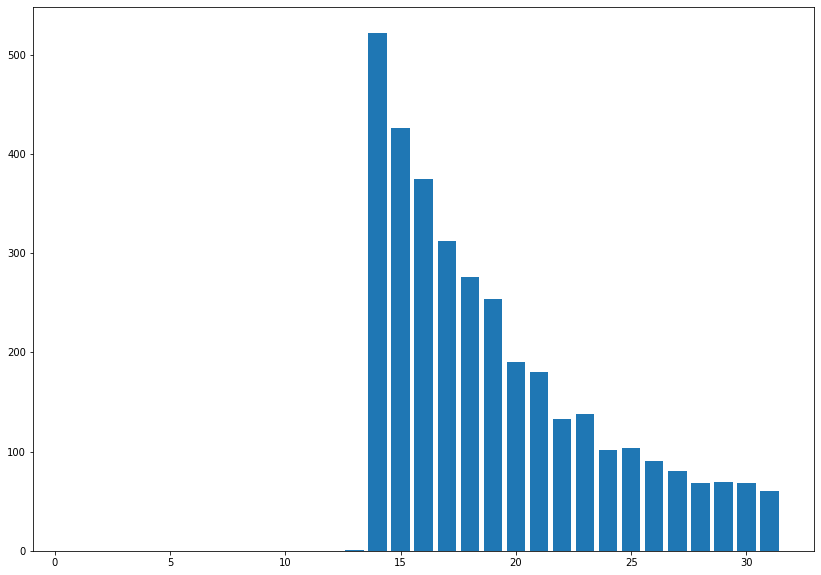

In [69]:
if SHOW_SAT_RESULTS:
    with open(SAT_TEST_SEQ.replace("input", "results/sat") + ".json") as f:
        data = json.load(f)
        plt.figure(figsize=(14, 10))
        times = data["times"]
        n = len(times)
        calls = [i + 1 for i in range(n)]
        plt.bar(calls, times)
        # plt.yscale("log")
        tikzplotlib.save("sat.tex")
        plt.show()

In [70]:
def plot_data(result_dicts: list[dict[str, float | str]], indp_var: str):
    # TODO: Complete function to plot data to compare indp vars, where x axis is length, y axis is time taken
    mapped_results: dict[str, list[dict]] = {}
    fig, ax_left = plt.subplots(figsize=(16, 10))
    ax_right = ax_left.twinx()

    for r in result_dicts:
        key = r[indp_var]
        mapped_results[key] = mapped_results.get(key, []) + [r]

    # Loop through each 
    for i, (var, results) in enumerate(mapped_results.items()):
        data = []
        incl = ["len", "encode_time", "total_time", "sat_time"]
        for result in results:
            data.append({i: result[i] for i in incl})
        data.sort(key=lambda x:x["len"])

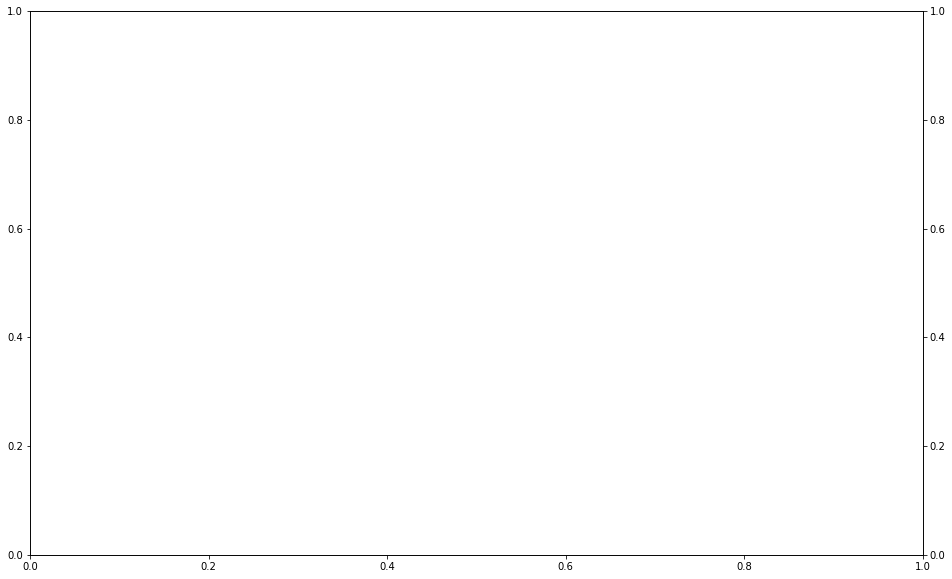

In [71]:
plot_data(get_result_dicts(POLICY_DIR), "policy")

# New graph

Same thing as above, have 6 curves
- Average runtime
- Average number of variables
- Average number of clauses

One graph for 2D, one graph for 3D

Cactus plot
Fix an encoding
Solve all the instances, for each instance record how long it took
Then sort the times, and plot cumulative time as we go through sorted list

If we have instances [a, b, c, d]
Solving times are [3, 10, 2, 1] respectively
Sorted case is [1, 2, 3, 10]
Data points are [(1, 1), (2, 3), (3, 6), (4, 16)]
Do this for new and old encoding, on the same picture, and instances can be of different lengths

x axis: 